# Cyberbullying On Social Media

# Convolutional Neural Networks

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns
import os
import math

# ! pip install imbalanced-learn
# check version number
import imblearn
# print(imblearn.__version__)
from imblearn.over_sampling import SMOTE


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Flatten, MaxPooling1D, Dense, Dropout, Activation, Input, BatchNormalization, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import concatenate

from PIL import Image

**CNN**

Convolutional Neural Network (CNN)  models were developed for image classification, in which the model accepts a two-dimensional input representing an image’s pixels and color channels, in a process called feature learning.

This same process can be applied to one-dimensional sequences of data. The model extracts features from sequences data and maps the internal features of the sequence. A 1D CNN is very effective for deriving features from a fixed-length segment of the overall dataset, where it is not so important where the feature is located in the segment.

CNNs work well for:

- Analysis of a time series of sensor data.
- Analysis of signal data over a fixed-length period, for example, an audio recording.
- Natural Language Processing (NLP), although according to my research, Recurrent Neural Networks which leverage Long Short Term Memory (LSTM) cells might be more promising than CNN as they take into account the proximity of words to create trainable patterns.


CNNs work the same way whether they have 1, 2, or 3 dimensions. The difference is the structure of the input data and how the filter, also known as a convolution kernel or feature detector, moves across the data.


The idea of using a CNN to classify text was first presented in the paper Convolutional Neural Networks for Sentence Classification by Yoon Kim. Instead of image pixels, the input to the tasks are sentences or documents represented as a matrix. Each row of the matrix corresponds to one word vector. That is, each row is word-vector that represents a word. Thus a sequence of max length 100 gives us a image of 100 (max sequence length)x300(embedding size).

The intuition behind it is that for a image we move our conv filter horizontally. By comparison here we are just going to move down for the convolution taking look at three words at once since I start with a filter size of 3 for this probelm. Also one can think of filter sizes as unigrams, bigrams, trigrams etc. since we are looking at a context window of 1,2,3, and 5 words respectively. 

In [2]:
# keep the same random state for reproducibility
RANDOM_STATE = 12

TRAIN_TEST_SPLIT_SIZE = 0.1
VALIDATION_SPLIT_SIZE = 0.2

In [3]:
df = pd.read_csv('labeled_insta_cleaned.csv', encoding = 'utf-8-sig', engine = 'python')

In [4]:
comments = df['tidy_text'].values
labels = df['label_bullying'].values

In [5]:
x_train_val, x_test, y_train_val, y_test = train_test_split(comments, labels, stratify = labels, test_size = TRAIN_TEST_SPLIT_SIZE, random_state = RANDOM_STATE)

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify = y_train_val, test_size = VALIDATION_SPLIT_SIZE, random_state = RANDOM_STATE)

In [7]:
# MAX_SEQUENCE_LENGTH = max(len(x) for x in x_train) # longest text in train set
# instead of max use average length of sentences in train set
MAX_SEQUENCE_LENGTH = 50

***

**Utility Functions**

In [8]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [9]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

In [10]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2 , n+1)
        plt.plot(history.epoch,  history.history[metric], color = colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_' + metric], color = colors[1], linestyle = "--", label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        plt.legend()

In [11]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [12]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth = 2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth = 2, color = colors[6], linestyle = ':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

***

**Prepare datasets**

***

In [13]:
# Tokenize and transform to integer index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(comments)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_val = tokenizer.texts_to_sequences(x_val)

x_train = pad_sequences(x_train, maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(x_test, maxlen = MAX_SEQUENCE_LENGTH)
x_val = pad_sequences(x_val, maxlen = MAX_SEQUENCE_LENGTH)

In [14]:
word_index = tokenizer.word_index
print('Unique tokens:', len(word_index))

MAX_NUM_WORDS = len(word_index) + 1

Unique tokens: 55121


In [15]:
#transform the training dataset only
sm = SMOTE(random_state = RANDOM_STATE)
x_train_sm, y_train_sm = sm.fit_sample(x_train, y_train)

Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

In [16]:
scaler = StandardScaler()

# x_train = scaler.fit_transform(x_train)
x_train_sm = scaler.fit_transform(x_train_sm)

x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [17]:
print('Training dataset shape:', x_train.shape)
print('Resampled training dataset shape:', x_train_sm.shape)
print('Validation dataset shape:', x_val.shape)
print('Test dataset shape:', x_test.shape)

Training dataset shape: (7943, 50)
Resampled training dataset shape: (11304, 50)
Validation dataset shape: (1986, 50)
Test dataset shape: (1104, 50)


**Define the model and metrics**



Currently, F1-score cannot be meaningfully used as a metric in keras neural network models, because keras will call F1-score at each batch step at validation, which results in too small values. Therefore, F1-score was removed from keras. Fortunately keras still provides precision, recall and auc as metrics.

In [18]:
KERAS_METRICS = [
      keras.metrics.TruePositives(name = 'tp'),
      keras.metrics.FalsePositives(name = 'fp'),
      keras.metrics.TrueNegatives(name = 'tn'),
      keras.metrics.FalseNegatives(name = 'fn'), 
      keras.metrics.BinaryAccuracy(name = 'accuracy'),
      keras.metrics.Precision(name = 'precision'),
      keras.metrics.Recall(name = 'recall'),
      keras.metrics.AUC(name = 'auc'),
]

The general taks here is to define a function that creates a convoluted neural network with a densly connected hidden layer, a dropout layer to reduce overfitting, and an output sigmoid layer that returns the probability of a comment as being bullying.

**The generic architecture of the model** 

I've decided to use groups of two 1D CNN layers, followed by a pooling layer, then a dropout layer for regularization. It is common to define CNN layers in groups of two in order to give the model a good chance of learning features from the input data. CNNs learn very quickly, so the dropout layer is intended to help slow down the learning process and hopefully result in a better final model. The pooling layer reduces the learned features to 1/2 their size, consolidating them to only the most essential elements.

After the CNN and pooling, the learned features are flattened to one long vector and pass through a fully connected layer before the output layer used to make a prediction. The fully connected layer ideally provides a buffer between the learned features and the output with the intent of interpreting the learned features before making a prediction.

Batch normalization scales and shifts the layer output with the mean and variance calculated over the batch, so that the input to the next layer is more robust against internal covariate shift. Dropout randomly drops elements of its input, teaching the following layers not to rely on specific features or elements, but to use all information available. This enforces the network to generalize better and is a mean to reduce overfitting

The efficient Adam version of stochastic gradient descent will be used to optimize the network, and the binary cross entropy loss function will be used given that we are learning a binary classification problem.

Additionally, there are two options to vectorize the data for Keras:

- **Option 1**: Make it part of the model, so as to obtain a model that processes raw strings. This is what we will do here with the Keras Embeddings Layer, and later using the pretrained Glove/FastTest embeddings. If we don't specify a custom way to embed text (something we will do later with Glove/FastTest) Keras will do it randomly with a normal (Gaussian) distribution for us.

- **Option 2**: Apply it to the text dataset to obtain a dataset of word indices, then feed it into a model that expects integer sequences as inputs. This is what we will do with TFIDF and Word2Vec.

**Embedding Layer**

Keras offers an Embedding layer that can be used for neural networks on text data. It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras. The Embedding layer is initialized with random weights and will learn an embedding for all of the words in the training dataset.

It is a flexible layer that can be used in a variety of ways, such as:
- It can be used alone to learn a word embedding that can be saved and used in another model later.
- It can be used as part of a deep learning model where the embedding is learned along with the model itself.
- It can be used to load a pre-trained word embedding model, a type of transfer learning.

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:
- input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words. Using the Keras tokenizer we set this value as MAX_NUM_WORDS = len(word_index) + 1.
- output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. I have tested different values for this problem: 32, 64, 100 and 300. 
- input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. 

**Number of epochs and batch size**

The number of epochs and the batch size are also tunable parameters. We would in general want to use a larger batch size to train the model as it allows computational speed up from the parallelism. However, it is known that too large of a batch size will lead to poor generalization (although currently it’s not known why this is so). I have experimented with batch sizes of 16, 32, 64 and 128, and let the algorithm run for 100 epochs. In order to prevent overfitting I relied on early stopping.

**Early stopping**

When we’re training a learning algorithm iteratively, we can measure how well each iteration of the model performs. Up until a certain number of iterations, new iterations improve the model. After that point, however, the model’s ability to generalize can weaken as it begins to overfit the training data. Early stopping refers stopping the training process before the learner passes that point.

**Hyperparamters Tuning**

Tuning machine learning hyperparameters is a tedious yet crucial task, as the performance of an algorithm can be highly dependent on the choice of hyperparameters. Grid and random search are hands-on, but require long run times because they waste time evaluating unpromising areas of the search space. As a side note, I have also tried to use GridSearchCV, RandomizedSearchCV and hyperopt for the selection of the best parameters. However, I did not manage to parallelize the work (some known issues related to the version of the KerasClassifier wrapper which was incompatible to my environment). Running sequentially was proving to be too computationally expensive, so I decided to tune the parameters manually, by trial and error. 

- Kernel sizes: 3, 5, 7.
- Number of filters (feature maps): 16, 32, 64, 128.
- Dropout rates: 0.01, 0.05, 0.1, 0.5.
- Batch normalization: yes/no
- Second group of conv layers present: yes/no
- Dense layer: 64, 128, 256.


The feature maps are the number of times the input is processed or interpreted, whereas the kernel size is the number of input time steps considered as the input sequence is read or processed onto the feature maps (via the convolutional process).

A kernel size of 3 did not produce a model capable of learning at all. I tried different ways to tune the hyperparameters: 16, 32, 64 number of filters, various dropouts from 0.05 to 0.5, with and without batch normalization, size of embeddings from 30 to 300. At this point I increased the patience on early stopping from 10 to 20 to see if the performance gets a chance to improve. Still I did not manage to achieve any presentable results (F1 score as low as 0.2 and AUC of 0.5).

A kernel size of 5 helped the model to learn. A large kernel size means a less rigorous reading of the data, but in this case resulted in a more generalized snapshot of the input. Increasing the kernel size beyond that lead to poor performance of the model again. So I decided to keep the kernel size fixed at 5, and try to further tune the other parameters.  

This helped me also understand better how the model works. In total I have tried over 50 different configurations, and the one I'm presenting below gave the best results.

**Concrete implementation**

For this model, I have settled on a standard configuration of 16 parallel feature maps and a kernel size of 5. I.e. with a kernel size of 5, 16 x 5-grams are constructed each representing a specific feature. 

In [19]:
EMBEDDING_DIM = 300

WEIGHT_DECAY = 0.0005
NO_FILTERS = 16
KERNEL_SIZE = 5
DROPOUT = 0.5
LEARNING_RATE = 0.001 #default

In [20]:
def make_model(add_conv_layer = False, add_dense_layer = False):
    
    model = Sequential()
    model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length = MAX_SEQUENCE_LENGTH))

    model.add(Conv1D(filters = NO_FILTERS, kernel_size = KERNEL_SIZE, kernel_regularizer = l2(WEIGHT_DECAY), bias_regularizer = l2(WEIGHT_DECAY), activation = 'relu', padding='same', input_shape = (x_train_sm.shape[1], 1)))
#     model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))

    model.add(Conv1D(filters = NO_FILTERS, kernel_size = KERNEL_SIZE, kernel_regularizer = l2(WEIGHT_DECAY), bias_regularizer = l2(WEIGHT_DECAY), activation = 'relu', padding='same'))
#     model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))
    
    if add_conv_layer:
        model.add(Conv1D(filters = NO_FILTERS*4, kernel_size = KERNEL_SIZE, kernel_regularizer = l2(WEIGHT_DECAY), bias_regularizer = l2(WEIGHT_DECAY), activation = 'relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size = 2))

        model.add(Conv1D(filters = NO_FILTERS*8, kernel_size = KERNEL_SIZE, kernel_regularizer = l2(WEIGHT_DECAY), bias_regularizer = l2(WEIGHT_DECAY), activation = 'relu', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size = 2))

    model.add(Flatten())

    if add_dense_layer:

        model.add(Dropout(rate = DROPOUT))
        model.add(Dense(256, activation = 'relu'))
        
    model.add(Dropout(rate = DROPOUT))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(rate = DROPOUT))
    
    opt = Adam(lr = LEARNING_RATE)
    # Finally, we feed the output into a Sigmoid layer, because we are trying to achieve a binary classification(1,0)
    # For each label, and the sigmoid function will squash the output between the bounds of 0 and 1.
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = [KERAS_METRICS])
    model.summary()
    return model

In [21]:
model = make_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           16536600  
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 16)            24016     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 16)            1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dropout (Dropout)            (None, 192)               0

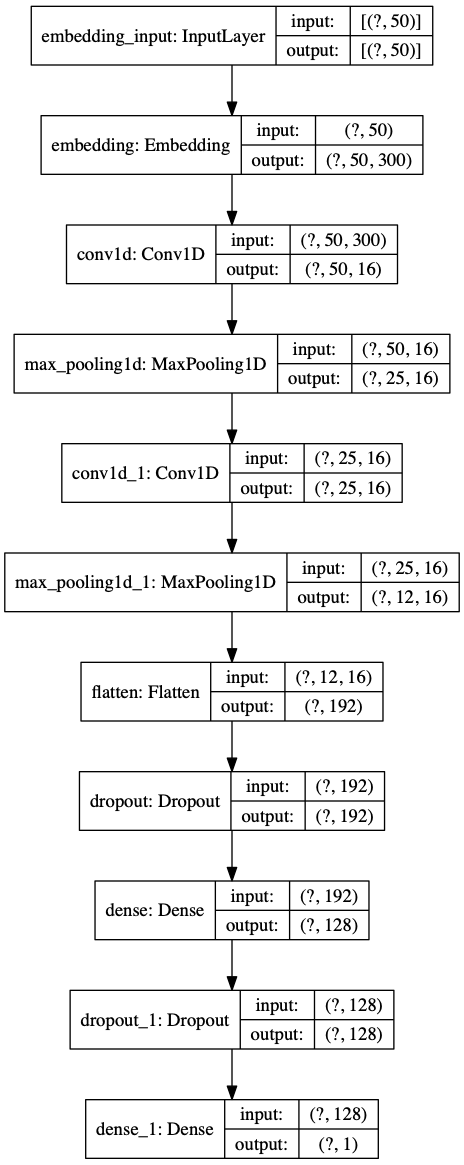

In [22]:
plot_model(model, to_file = 'model_keras.png', show_shapes = True, show_layer_names = True)
im = Image.open('model_keras.png')
im

In [23]:
# The exact amount of patience will vary between models and problems and is difficult to calculate exactly. 
# As a rule of thumb to use 10% of the number of epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_auc', 
    verbose = 2,
    patience = 10,
    mode = 'max',
    restore_best_weights = True)

In [24]:
callbacks = [early_stopping]

In [25]:
BATCH_SIZE = 64
EPOCHS = 100

In [26]:
history = model.fit(x_train_sm, y_train_sm, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        callbacks = callbacks,
                        validation_data = (x_val, y_val))

Train on 11304 samples, validate on 1986 samples
Epoch 1/100
11304/11304 [==============================] - 44s 4ms/sample - loss: 0.7037 - tp: 2487.0000 - fp: 2373.0000 - tn: 3279.0000 - fn: 3165.0000 - accuracy: 0.5101 - precision: 0.5117 - recall: 0.4400 - auc: 0.5145 - val_loss: 0.7072 - val_tp: 569.0000 - val_fp: 1409.0000 - val_tn: 4.0000 - val_fn: 4.0000 - val_accuracy: 0.2885 - val_precision: 0.2877 - val_recall: 0.9930 - val_auc: 0.5204
Epoch 2/100
11304/11304 [==============================] - 38s 3ms/sample - loss: 0.6923 - tp: 3815.0000 - fp: 3540.0000 - tn: 2112.0000 - fn: 1837.0000 - accuracy: 0.5243 - precision: 0.5187 - recall: 0.6750 - auc: 0.5360 - val_loss: 0.6882 - val_tp: 413.0000 - val_fp: 921.0000 - val_tn: 492.0000 - val_fn: 160.0000 - val_accuracy: 0.4557 - val_precision: 0.3096 - val_recall: 0.7208 - val_auc: 0.5402
Epoch 3/100
11304/11304 [==============================] - 39s 3ms/sample - loss: 0.6840 - tp: 4620.0000 - fp: 4116.0000 - tn: 1536.0000 - fn: 103

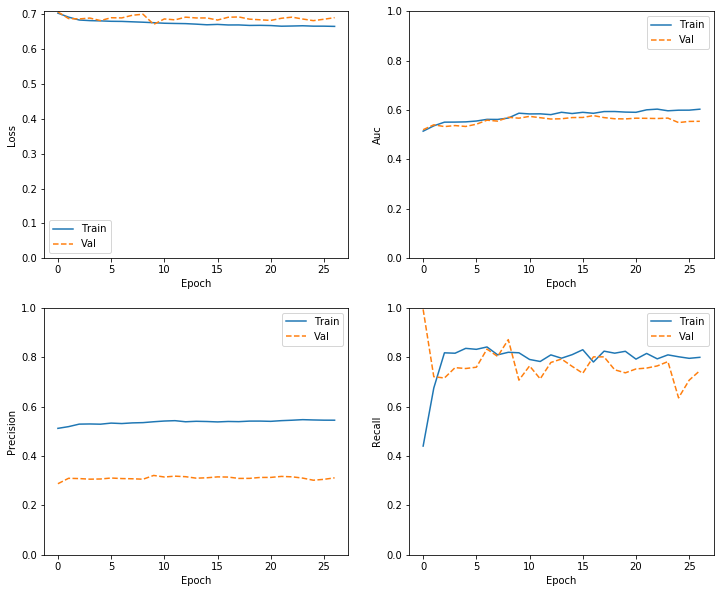

In [27]:
plot_metrics(history)

The results on the validation data set are a little bit noisy, but the model doesn't overfit too badly.

In [28]:
y_probas_train_keras = model.predict(x_train_sm)
y_probas_test_keras = model.predict(x_test)

In [29]:
y_pred_test_keras = np.round(y_probas_test_keras) 

True Negatives:  224
False Positives:  561
False Negatives:  61
True Positives:  258


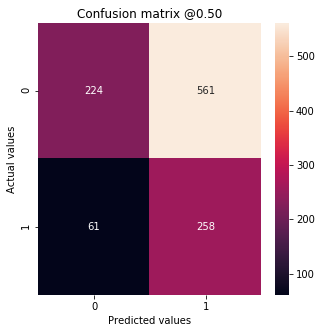

In [30]:
plot_cfm(y_test, y_probas_test_keras)

In [31]:
print(classification_report(y_test, y_pred_test_keras))

              precision    recall  f1-score   support

           0       0.79      0.29      0.42       785
           1       0.32      0.81      0.45       319

    accuracy                           0.44      1104
   macro avg       0.55      0.55      0.44      1104
weighted avg       0.65      0.44      0.43      1104



In [32]:
f1_keras = f1_score(y_test, y_pred_test_keras, average = 'weighted')
print('Keras F1: %.2f' % f1_keras)

Keras F1: 0.43


In [33]:
auc_keras = roc_auc_score(y_test, y_probas_test_keras)
print('Keras AUC: %.2f' % auc_keras)

Keras AUC: 0.57


As a side note: I have been able to obtain slightly better results with this configuration: F1 = 0.524 and AUC = 0.620. Since I did not set the random seed, I haven't been able to reproduce the same results again unfortunately. This is as close as I've came to those results. On the whole I am quite content with these results though, taking into account that I've spent a considerable amount of time tuning this model. Even though other classifiers obtained better results in terms of the metrics chosen, this configuration has outperformed all other classifiers in terms of the rate of true positives (predicting the bullying comments). None of the other classifiers have been able to obtain a 81% recall on the negative class. This comes at the cost of lower precision.

Strangely enough though, the F1 score is much worse than without using the embeddings, and by far the worse I've had for the entire project.

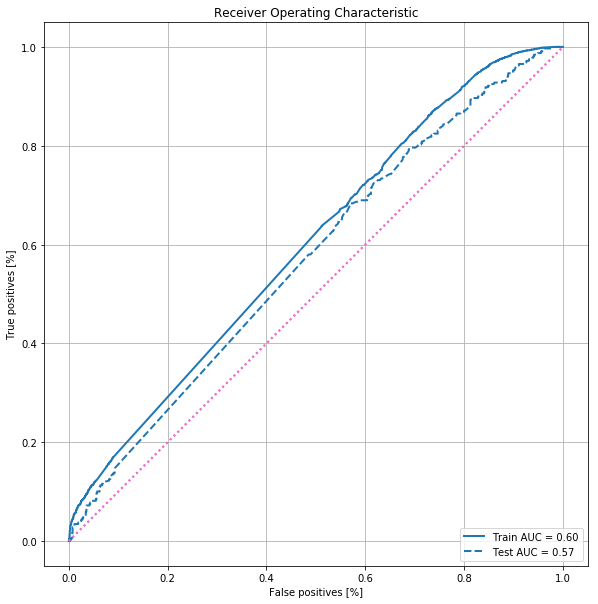

In [34]:
plot_roc("Train", y_train_sm, y_probas_train_keras, color = colors[0])
plot_roc("Test", y_test, y_probas_test_keras, color = colors[0], linestyle = '--')

***

**Pretrained Embeddings**

***

The Keras Embedding layer can also use a word embedding learned elsewhere. It is common in the field of Natural Language Processing to learn, save, and make freely available word embeddings.

For example, the researchers behind GloVe method provide a suite of pre-trained word embeddings on their website released under a public domain license. In addition to GloVe I will also use FastText.

In [35]:
GLOVE_PATH = 'glove.twitter.27B.200d.txt'

In [36]:
FASTTEXT_PATH = 'crawl-300d-2M.vec'

In [37]:
EMBEDDING_DIM_FTEXT = 300
EMBEDDING_DIM_GLOVE = 200

In [38]:
embeddings_index_glove = {}
all_words = set(w for words in comments for w in words)
f = open((GLOVE_PATH))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_glove[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index_glove))

Found 1193514 word vectors.


In [39]:
embeddings_index_ftext = {}
f = open((FASTTEXT_PATH))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_ftext[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index_ftext))

Found 1999996 word vectors.


I'm going to first initialize the embedding matrix to zeros just to easily check the coverage of the vocabulary (remaining number of null word embeddings).

In [40]:
embedding_matrix_glove = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM_GLOVE))
for word, i in word_index.items():
    embedding_vector = embeddings_index_glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_glove[i] = embedding_vector

First, let’s have a quick look at how many of the embedding vectors are nonzero:

In [41]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix_glove, axis = 1))
nonzero_elements / len(word_index)

0.6336242085593512

This means 63.36% of the vocabulary is covered by the pretrained model.

In [42]:
print('Number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix_glove, axis = 1) == 0))

Number of null word embeddings: 20196


In [43]:
embedding_matrix_ftext = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM_FTEXT))
for word, i in word_index.items():
    embedding_vector = embeddings_index_ftext.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ftext[i] = embedding_vector

In [44]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix_ftext, axis = 1))
nonzero_elements / len(word_index)

0.5915531285716877

FastText provides a 59.15% coverage of our vocabulary.

In [45]:
print('Number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix_ftext, axis = 1) == 0))

Number of null word embeddings: 22515


In [46]:
embedding_matrix_concat = np.concatenate((embedding_matrix_glove, embedding_matrix_ftext), axis = -1)

In [47]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix_concat, axis = 1))
nonzero_elements / len(word_index)

0.6749514704014804

Concatenating the two matrices improves the coverage to 67.49%. Since the embeddings for Glove and FastText have different dimensions, simply averaging them will not work out of the box (unless I padd the Glove embeddings with zeros, perhaps). I will try two different approaches here:

- use the concantenated matrix (dimension 500). The disadvantage here is the bigger dimension
- use the embeddings as weights for two separate models which I later merge/concateate into one single model inside Keras.

Now that we've seen the coverage of the vocabulary I will recreate the matrices again, this using a random initialization instead of zeros. I initially had the matrices initialized with zeros, but any random initialization proved to improve the performance.

In [48]:
embedding_matrix_glove = np.random.uniform(-0.25, 0.25,(MAX_NUM_WORDS, EMBEDDING_DIM_GLOVE))
for word, i in word_index.items():
    embedding_vector = embeddings_index_glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be randomly initialized.
        embedding_matrix_glove[i] = embedding_vector

In [49]:
embedding_matrix_ftext = np.random.uniform(-0.25, 0.25,(MAX_NUM_WORDS, EMBEDDING_DIM_FTEXT))
for word, i in word_index.items():
    embedding_vector = embeddings_index_ftext.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be randomly initialized.
        embedding_matrix_ftext[i] = embedding_vector

In [50]:
embedding_matrix_concat = np.concatenate((embedding_matrix_glove, embedding_matrix_ftext), axis = -1)

With the embedding matrices created, it's time to feed them as weights to the CNN in the Keras Embedding Layer. I've decided to try two different approaches (inspired by [Kim's paper](http://www.aclweb.org/anthology/D14-1181)), one using the combined concatenation of the two pretrained embeddings, and another one inspired from his CNN-multichannel approach. Here Kim uses two sets of word vectors, he applies both to the input data set (resulting in two, sentence_length x 300D matrices) and then he performs convolutions on both. During training he fine tunes one embedding but keeps the other one fixed. He hoped it would act as a form of regularization but the results were mixed. Since I have two types of pretrained embeddings, I will allow them both to be retrained. Based on my failed experiences this improves the performance of the model.

**Approach 1:**

In [51]:
WEIGHT_DECAY = 0.0005
NO_FILTERS = 16
KERNEL_SIZE = 5
DROPOUT = 0.5
LEARNING_RATE = 0.001
COMBINED_EMBEDDING_DIM = 500

In [52]:
def make_embed_model(add_conv_layer = False, add_dense_layer = False):
    
    model = Sequential()
    model.add(Embedding(MAX_NUM_WORDS, COMBINED_EMBEDDING_DIM, weights = [embedding_matrix_concat], input_length = MAX_SEQUENCE_LENGTH))

    model.add(Conv1D(filters = NO_FILTERS, kernel_size = KERNEL_SIZE, kernel_regularizer = l2(WEIGHT_DECAY), bias_regularizer = l2(WEIGHT_DECAY), activation = 'relu', padding='same', input_shape = (x_train_sm.shape[1], 1)))
#     model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))

    model.add(Conv1D(filters = NO_FILTERS, kernel_size = KERNEL_SIZE, kernel_regularizer = l2(WEIGHT_DECAY), bias_regularizer = l2(WEIGHT_DECAY), activation = 'relu', padding='same'))
#     model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))
    
    if add_conv_layer:
        model.add(Conv1D(filters = NO_FILTERS*4, kernel_size = KERNEL_SIZE, kernel_regularizer = l2(WEIGHT_DECAY), bias_regularizer = l2(WEIGHT_DECAY), activation = 'relu', padding='same'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size = 2))

        model.add(Conv1D(filters = NO_FILTERS*8, kernel_size = KERNEL_SIZE, kernel_regularizer = l2(WEIGHT_DECAY), bias_regularizer = l2(WEIGHT_DECAY), activation = 'relu', padding='same'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size = 2))

    model.add(Flatten())

    if add_dense_layer:

        model.add(Dropout(rate = DROPOUT))
        model.add(Dense(512, activation = 'relu'))
        
    model.add(Dropout(rate = DROPOUT))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(rate = DROPOUT))
    
    opt = Adam(lr = LEARNING_RATE)
    # Finally, we feed the output into a Sigmoid layer, because we are trying to achieve a binary classification(0,1)
    # For each label, and the sigmoid function will squash the output between the bounds of 0 and 1.
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = [KERAS_METRICS])
    model.summary()
    return model

In [53]:
emb_model = make_embed_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 500)           27561000  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 16)            40016     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 16)            1296      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 12, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 192)              

In [54]:
history = emb_model.fit(x_train_sm, y_train_sm, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        callbacks = callbacks,
                        validation_data = (x_val, y_val))

Train on 11304 samples, validate on 1986 samples
Epoch 1/100
11304/11304 [==============================] - 71s 6ms/sample - loss: 0.7102 - tp: 3558.0000 - fp: 3347.0000 - tn: 2305.0000 - fn: 2094.0000 - accuracy: 0.5187 - precision: 0.5153 - recall: 0.6295 - auc: 0.5224 - val_loss: 0.6901 - val_tp: 373.0000 - val_fp: 845.0000 - val_tn: 568.0000 - val_fn: 200.0000 - val_accuracy: 0.4738 - val_precision: 0.3062 - val_recall: 0.6510 - val_auc: 0.5314
Epoch 2/100
11304/11304 [==============================] - 66s 6ms/sample - loss: 0.6948 - tp: 4333.0000 - fp: 3871.0000 - tn: 1781.0000 - fn: 1319.0000 - accuracy: 0.5409 - precision: 0.5282 - recall: 0.7666 - auc: 0.5550 - val_loss: 0.6886 - val_tp: 405.0000 - val_fp: 909.0000 - val_tn: 504.0000 - val_fn: 168.0000 - val_accuracy: 0.4577 - val_precision: 0.3082 - val_recall: 0.7068 - val_auc: 0.5435
Epoch 3/100
11304/11304 [==============================] - 66s 6ms/sample - loss: 0.6867 - tp: 4766.0000 - fp: 4314.0000 - tn: 1338.0000 - fn: 

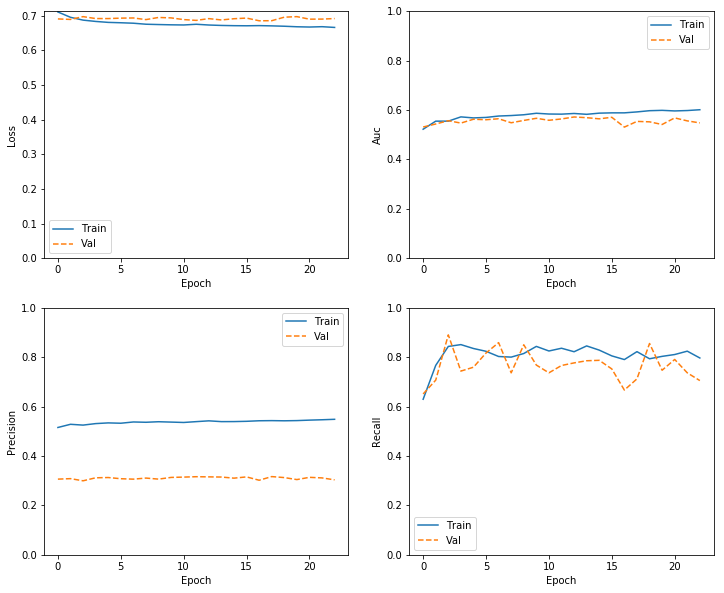

In [55]:
plot_metrics(history)

In [56]:
y_probas_train_emb = emb_model.predict(x_train_sm)
y_probas_test_emb = emb_model.predict(x_test)

In [57]:
y_pred_test_emb = np.round(y_probas_test_emb) 

True Negatives:  252
False Positives:  533
False Negatives:  69
True Positives:  250


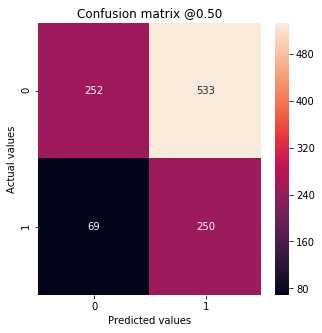

In [58]:
plot_cfm(y_test, y_probas_test_emb)

In [59]:
print(classification_report(y_test, y_pred_test_emb))

              precision    recall  f1-score   support

           0       0.79      0.32      0.46       785
           1       0.32      0.78      0.45       319

    accuracy                           0.45      1104
   macro avg       0.55      0.55      0.45      1104
weighted avg       0.65      0.45      0.46      1104



In [60]:
f1_emb = f1_score(y_test, y_pred_test_emb, average = 'weighted')
print('Pretrained Embeddings F1: %.2f' % f1_emb)

Pretrained Embeddings F1: 0.46


In [61]:
auc_emb = roc_auc_score(y_test, y_probas_test_emb)
print('Pretrained Embeddings AUC: %.2f' % auc_emb)

Pretrained Embeddings AUC: 0.56


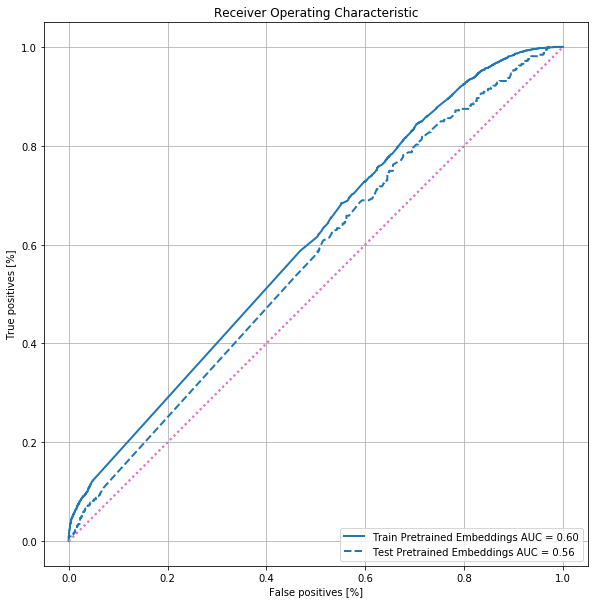

In [62]:
plot_roc("Train Pretrained Embeddings", y_train_sm, y_probas_train_emb, color = colors[0])
plot_roc("Test Pretrained Embeddings", y_test, y_probas_test_emb, color = colors[0], linestyle = '--')

**Approach 2:**

In [63]:
WEIGHT_DECAY = 0.0005
NO_FILTERS = 16
KERNEL_SIZE = 5
DROPOUT = 0.5
LEARNING_RATE = 0.001

In [64]:
def make_concat_embed_model():
    
    model1 = Sequential()
    model1.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM_GLOVE, weights = [embedding_matrix_glove], input_length = MAX_SEQUENCE_LENGTH))

    model1.add(Conv1D(filters = NO_FILTERS, kernel_size = KERNEL_SIZE, kernel_regularizer = l2(WEIGHT_DECAY), bias_regularizer = l2(WEIGHT_DECAY), activation = 'relu', padding='same', input_shape = (x_train_sm.shape[1], 1)))
#     model1.add(BatchNormalization())
    model1.add(MaxPooling1D(pool_size = 2))

    model1.add(Conv1D(filters = NO_FILTERS, kernel_size = KERNEL_SIZE, kernel_regularizer = l2(WEIGHT_DECAY), bias_regularizer = l2(WEIGHT_DECAY), activation = 'relu', padding='same'))
#     model1.add(BatchNormalization())
    model1.add(MaxPooling1D(pool_size = 2))

    model1.add(Flatten())
    model1.add(Dropout(rate = DROPOUT))
    model1.add(Dense(128, activation = 'relu'))



    model2 = Sequential()
    model2.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM_FTEXT, weights = [embedding_matrix_ftext], input_length = MAX_SEQUENCE_LENGTH))

    model2.add(Conv1D(filters = NO_FILTERS, kernel_size = KERNEL_SIZE, kernel_regularizer = l2(WEIGHT_DECAY), bias_regularizer = l2(WEIGHT_DECAY), activation = 'relu', padding='same', input_shape = (x_train_sm.shape[1], 1)))
#     model2.add(BatchNormalization())
    model2.add(MaxPooling1D(pool_size = 2))

    model2.add(Conv1D(filters = NO_FILTERS*2, kernel_size = KERNEL_SIZE, kernel_regularizer = l2(WEIGHT_DECAY), bias_regularizer = l2(WEIGHT_DECAY), activation = 'relu', padding='same'))
#     model2.add(BatchNormalization())
    model2.add(MaxPooling1D(pool_size = 2))

    model2.add(Flatten())
    model2.add(Dropout(rate = DROPOUT))
    model2.add(Dense(128, activation = 'relu'))


    conc = Concatenate()([model1.output, model2.output])

    out = Dense(64, activation='relu')(conc)
    out = Dropout(rate = DROPOUT)(out)
    out = Dense(1, activation='sigmoid')(out)

    model = Model([model1.input, model2.input], out)
    opt = Adam(lr = LEARNING_RATE)
    # Finally, we feed the output into a Sigmoid layer, because we are trying to achieve a binary classification(0,1)
    # For each label, and the sigmoid function will squash the output between the bounds of 0 and 1.
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = [KERAS_METRICS])
    model.summary()
    return model

In [65]:
concat_emb_model = make_concat_embed_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_2_input (InputLayer)  [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3_input (InputLayer)  [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 200)      11024400    embedding_2_input[0][0]          
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 300)      16536600    embedding_3_input[0][0]          
______________________________________________________________________________________________

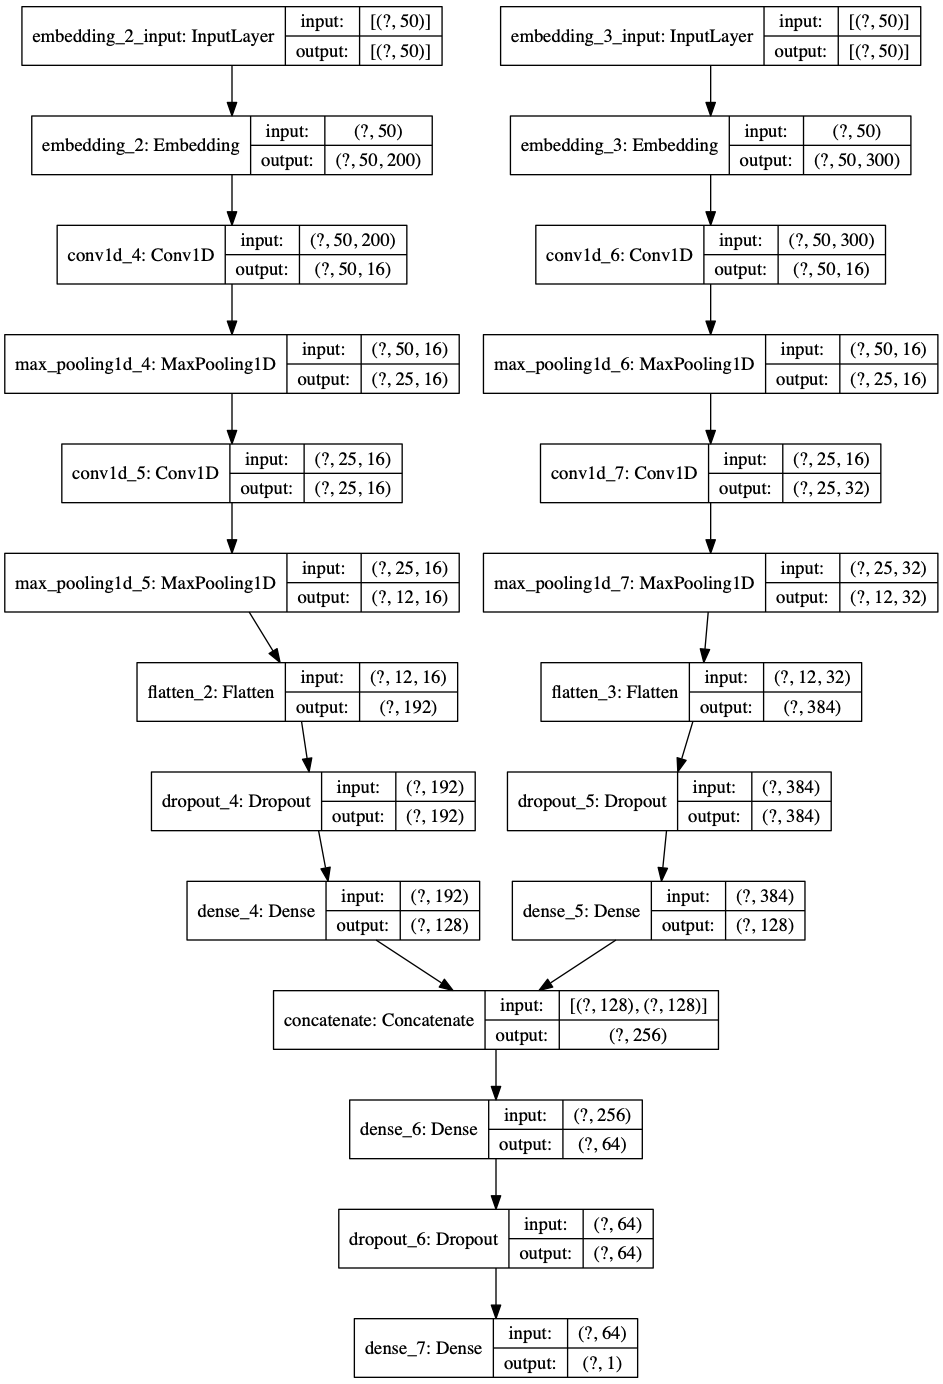

In [66]:
plot_model(concat_emb_model, to_file = 'concat_model_keras.png', show_shapes = True, show_layer_names = True)
im = Image.open('concat_model_keras.png')
im

In [67]:
history = concat_emb_model.fit([x_train_sm, x_train_sm], y_train_sm, 
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        callbacks = callbacks,
                        validation_data = ([x_val, x_val], y_val))

Train on 11304 samples, validate on 1986 samples
Epoch 1/100
11304/11304 [==============================] - 63s 6ms/sample - loss: 0.7291 - tp: 2854.0000 - fp: 2687.0000 - tn: 2965.0000 - fn: 2798.0000 - accuracy: 0.5148 - precision: 0.5151 - recall: 0.5050 - auc: 0.5202 - val_loss: 0.7092 - val_tp: 338.0000 - val_fp: 835.0000 - val_tn: 578.0000 - val_fn: 235.0000 - val_accuracy: 0.4612 - val_precision: 0.2882 - val_recall: 0.5899 - val_auc: 0.5032
Epoch 2/100
11304/11304 [==============================] - 60s 5ms/sample - loss: 0.7036 - tp: 4420.0000 - fp: 3939.0000 - tn: 1713.0000 - fn: 1232.0000 - accuracy: 0.5426 - precision: 0.5288 - recall: 0.7820 - auc: 0.5510 - val_loss: 0.7109 - val_tp: 498.0000 - val_fp: 1139.0000 - val_tn: 274.0000 - val_fn: 75.0000 - val_accuracy: 0.3887 - val_precision: 0.3042 - val_recall: 0.8691 - val_auc: 0.5511
Epoch 3/100
11304/11304 [==============================] - 60s 5ms/sample - loss: 0.6911 - tp: 4622.0000 - fp: 4017.0000 - tn: 1635.0000 - fn: 

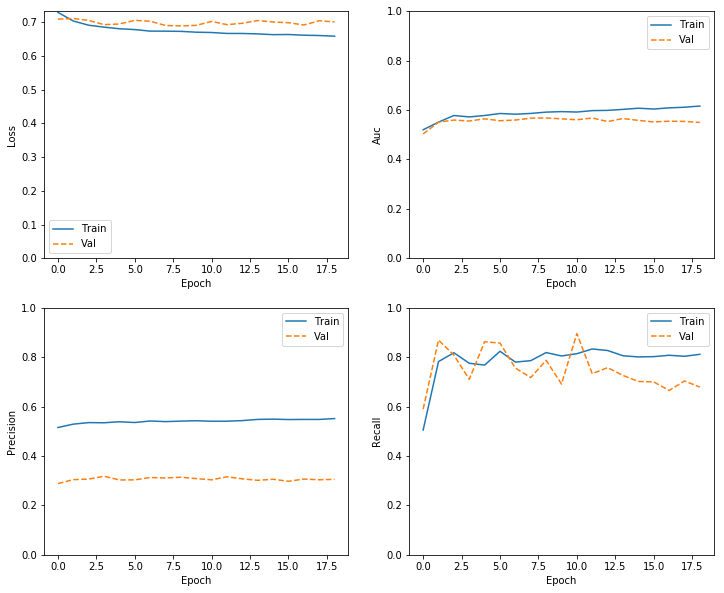

In [68]:
plot_metrics(history)

In [69]:
y_probas_train_emb_concat = concat_emb_model.predict([x_train_sm, x_train_sm])
y_probas_test_emb_concat = concat_emb_model.predict([x_test, x_test])

In [70]:
y_pred_test_emb_concat = np.round(y_probas_test_emb_concat) 

True Negatives:  244
False Positives:  541
False Negatives:  67
True Positives:  252


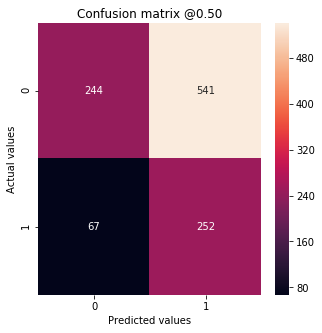

In [71]:
plot_cfm(y_test, y_probas_test_emb_concat)

In [72]:
print(classification_report(y_test, y_pred_test_emb_concat))

              precision    recall  f1-score   support

           0       0.78      0.31      0.45       785
           1       0.32      0.79      0.45       319

    accuracy                           0.45      1104
   macro avg       0.55      0.55      0.45      1104
weighted avg       0.65      0.45      0.45      1104



In [73]:
f1_emb_concat = f1_score(y_test, y_pred_test_emb_concat, average = 'weighted')
print('Pretrained Embeddings F1: %.2f' % f1_emb_concat)

Pretrained Embeddings F1: 0.45


In [74]:
auc_emb_concat = roc_auc_score(y_test, y_probas_test_emb_concat)
print('Pretrained Embeddings AUC: %.2f' % auc_emb_concat)

Pretrained Embeddings AUC: 0.57


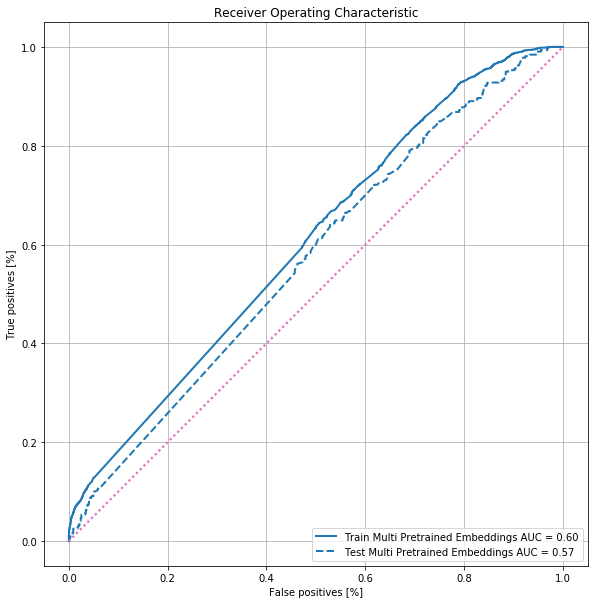

In [75]:
plot_roc("Train Multi Pretrained Embeddings", y_train_sm, y_probas_train_emb_concat, color = colors[0])
plot_roc("Test Multi Pretrained Embeddings", y_test, y_probas_test_emb_concat, color = colors[0], linestyle = '--')

Here we notice a similar trend as when using the Keras Embeddings. I think it's safe to generalize that for this data set, the CNNs perform much better without using the Embeddings Layer of Keras (irrespective of whethere the embeddings are pretrained or not). The CNNs seem to perform better without.

***

**Comparison**

In [76]:
import tabletext

data = [["Classifier", "F1", "AUC"],
        ["CNN w. Keras Embeddings", f1_keras, auc_keras],
        ["CNN w. Pretrained Embeddings", f1_emb, auc_emb],
        ["CNN w. Multi Pretrained Embeddings", f1_emb_concat, auc_emb_concat],
        ]

print (tabletext.to_text(data))

┌────────────────────────────────────┬─────────────────────┬────────────────────┐
│ Classifier                         │ F1                  │ AUC                │
├────────────────────────────────────┼─────────────────────┼────────────────────┤
│ CNN w. Keras Embeddings            │ 0.42872837947433984 │ 0.5711598746081505 │
├────────────────────────────────────┼─────────────────────┼────────────────────┤
│ CNN w. Pretrained Embeddings       │  0.4551253270766349 │ 0.5642812930535311 │
├────────────────────────────────────┼─────────────────────┼────────────────────┤
│ CNN w. Multi Pretrained Embeddings │ 0.44756184896576545 │ 0.5707126170556875 │
└────────────────────────────────────┴─────────────────────┴────────────────────┘


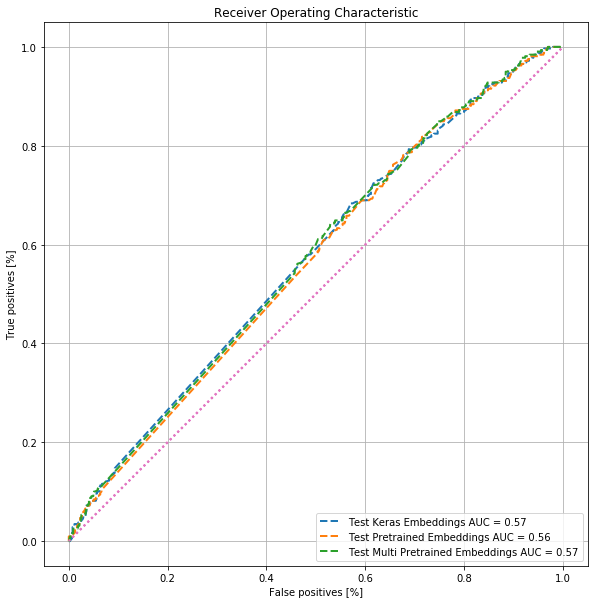

In [77]:
plot_roc("Test Keras Embeddings", y_test, y_probas_test_keras, color = colors[0], linestyle = '--')

plot_roc("Test Pretrained Embeddings", y_test, y_probas_test_emb, color = colors[1], linestyle = '--')

plot_roc("Test Multi Pretrained Embeddings", y_test, y_probas_test_emb_concat, color = colors[2], linestyle = '--')